## Mushroom classification 
By Christian Mayr



### Introduction

In this notebook I want to use a support vector machine to classify weather a mushroom is edible or poisonous. 

To do so, I found a dataset which contains data of over 60.000 hypothetical mushrooms from 173 species. I downloaded the data set from the following website:
https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset

This dataset was produced by Dennis Wagner, Dominik Heider and Georges Hattab and was the product of their bachelor thesis. This means this data was artificially produced using specifications from a biology book about these speciffic species of mushroom. This idea was inspired by a previous dataset:
https://archive.ics.uci.edu/dataset/73/mushroom

They used naive Bayes, logistic regression, and linear discriminant analysis (LDA), and random forests (RF) in their thesis to classify the mushrooms. 

A scientific report about their work is shown in the following page:
https://www.nature.com/articles/s41598-021-87602-3

In the results section of this paper, they figured out that they could archieve a AUC value of 1.00 and a perfect ROC courve by applying a random forest classifier. Because the data is simulated and this perfect courve looks very suspicious, I would like to try another supervised learning approach and see how it performs for this data set.

In the scope of this project I would like to see how a smv classifier performs for this kind of dataset. This is particulary interesting for me, because there are many categorical features in this data set. 

I think the two biggest challenges for this project will be a proper preparation of the data, because there are a lot of missing values in the data set as it seems, and be able to process the categorical values with the smv classifier.

### Data 

As mentioned before the dataset consits of 61068 Instances with 20 Features. They are organized in a tabule and stored in a .csv file. Every feature is listed below with the data type and possible values.

Variable Information:
   (n: nominal, m: metrical; nominal values as sets of values)
   1. cap-diameter (m):			float number in cm
   2. cap-shape (n):            bell=b, conical=c, convex=x, flat=f,
                                sunken=s, spherical=p, others=o
   3. cap-surface (n):          fibrous=i, grooves=g, scaly=y, smooth=s,
								shiny=h, leathery=l, silky=k, sticky=t,
								wrinkled=w, fleshy=e
   4. cap-color (n):            brown=n, buff=b, gray=g, green=r, pink=p,
								purple=u, red=e, white=w, yellow=y, blue=l, 
								orange=o,  black=k
   5. does-bruise-bleed (n):	bruises-or-bleeding=t,no=f
   6. gill-attachment (n):      adnate=a, adnexed=x, decurrent=d, free=e, 
								sinuate=s, pores=p, none=f, unknown=?
   7. gill-spacing (n):         close=c, distant=d, none=f
   8. gill-color (n):           see cap-color + none=f
   9. stem-height (m):			float number in cm
   10. stem-width (m):			float number in mm   
   11. stem-root (n):           bulbous=b, swollen=s, club=c, cup=u, equal=e,
                                rhizomorphs=z, rooted=r
   12. stem-surface (n): 		see cap-surface + none=f
   13. stem-color (n):			see cap-color + none=f
   14. veil-type (n):           partial=p, universal=u
   15. veil-color (n):          see cap-color + none=f
   16. has-ring (n):            ring=t, none=f
   17. ring-type (n):           cobwebby=c, evanescent=e, flaring=r, grooved=g, 
							    large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
   18. spore-print-color (n):   see cap color
   19. habitat (n):             grasses=g, leaves=l, meadows=m, paths=p, heaths=h,
                                urban=u, waste=w, woods=d
   20. season (n):				spring=s, summer=u, autumn=a, winter=w

### Data Cleaning

At first I want to load the dataset and take a first look at the header. I also want to load all necessary libraries in the beginning of the notebook. Then I can see all the used libraries at one glance. 

In [21]:
# Import all libraries for this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
#from matplotlib import rcParams


#### Load the data from the csv sheet into a pandas dataframe:

In [5]:
# Read in data file
df = pd.read_csv("secondary_data.csv", delimiter= ";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

By looking at the info table one can see that position 17 "ring-type" is missing just a few row. Therefore, I would drop the rows with the missing values since we have enough rows left for training and test. <br>
I would drop also the features that have less than 10,000 non-null values. They do not add significant informatioin to the model.

In [6]:
# copy all rows to df2 where ring-type is not na
df2 = df[df['ring-type'].notna()]
# drop columns with less then 10,000 na values
df2 = df2.drop(columns=['stem-root', 'veil-type', 'veil-color', 'spore-print-color'])

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58598 entries, 0 to 61068
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 58598 non-null  object 
 1   cap-diameter          58598 non-null  float64
 2   cap-shape             58598 non-null  object 
 3   cap-surface           44831 non-null  object 
 4   cap-color             58598 non-null  object 
 5   does-bruise-or-bleed  58598 non-null  object 
 6   gill-attachment       49067 non-null  object 
 7   gill-spacing          34594 non-null  object 
 8   gill-color            58598 non-null  object 
 9   stem-height           58598 non-null  float64
 10  stem-width            58598 non-null  float64
 11  stem-surface          21886 non-null  object 
 12  stem-color            58598 non-null  object 
 13  has-ring              58598 non-null  object 
 14  ring-type             58598 non-null  object 
 15  habitat               58

Next, I want to see if there are any 0 values in the float64 features. Since they are physical measurements, 0 values are treated like non existing measurements. If there are not too many, I will delete them from the dataframe.

In [7]:
# Count and print how many time 0 occures in cap-diameter column
zero_cap_dia = df2['cap-diameter'].value_counts().get(0)
print("Occurrences of '0' in cap dia:", zero_cap_dia)

# Count and print how many time 0 occures in stem-height column
zero_stmheight = df2['stem-height'].value_counts().get(0)
print("Occurrences of '0' in stem height:", zero_stmheight)

# Count and print how many time 0 occures in stem-width column
zero_stmwdt = df2['stem-width'].value_counts().get(0)
print("Occurrences of '0' in stem width:", zero_stmwdt)

Occurrences of '0' in cap dia: None
Occurrences of '0' in stem height: 1059
Occurrences of '0' in stem width: 1059


In [8]:
# copy all rows to df3 where stem-height is not 0, in other words drop all 0 values
df3 = df2[df2['stem-height'] != 0]

As a matter of fact, the zero values for the stem height and for the stem width were at the same rows. There are no zero values for these three features remaining. I ran the same code from above to be sure, but left it out to save some space in the notebook. 

### Exploratory Data Analysis (EDA)

I want to split my EDA in two parts. First, I am going to look into the continuous features with a pair plot and a correlation matrix to see the distribution of these features and check for possible multicollinearity. <br>
Second, I take a look at the nominal data. Here I have not much experience, but I want to plot the distribution of the values. Maybe I can drop a variable if I think it does not contribute much information to the model.

In [9]:
# Only select colums with continuous data and target
df_cont = df3.loc[:, ['class', 'cap-diameter', 'stem-height', 'stem-width']] 
# Drop all columns with continuous data 
df_nom = df3.drop(columns=['cap-diameter', 'stem-height', 'stem-width'])


#### Continuous Features

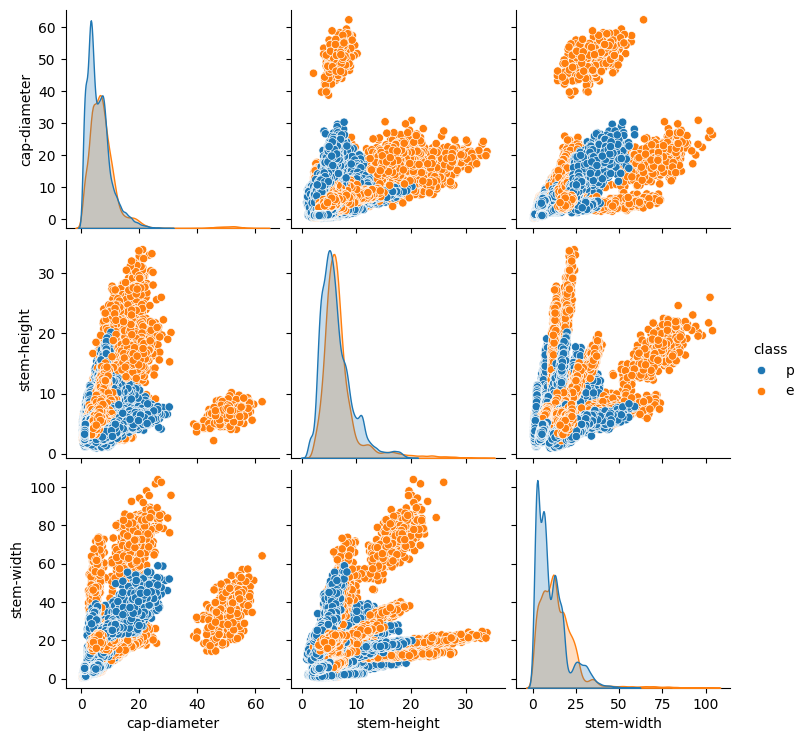

In [10]:
#Create pairplot with Seaborn library
sns.pairplot(df_cont, hue="class")
plt.show()

It looks like there is a correlation between the cap-diameter and the stem-width. To be sure I will create a correlation matrix in the next step.

In [11]:
# Create and display correlation matrix 
df_corr = df_cont.loc[:, ['cap-diameter', 'stem-height', 'stem-width']] 
corr = df_corr.corr()
corr

,cap-diameter,stem-height,stem-width
cap-diameter,1.000000,0.418431,0.695477
stem-height,0.418431,1.000000,0.420752
stem-width,0.695477,0.420752,1.000000


By looking at the correlation matrix one can see that there is a high correlation between the cap-diameter and the stem-width. For this reason I will drop the stem-width for the smv model.

#### Nominal Features

In [ ]:
''' in comments because it takes so much space, uncomment if you want to see the plots
lst = list(df_nom.columns.values)

cnt = 0
for val in lst:
    plt.figure(cnt)
    sns.countplot(data = df_nom, x = val)
    cnt +=1
'''

The plots for the nominal features did not show any specific reason to exclude one of them.<br>


### Modeling

First, I will prepare my data in a way to work with it during the modeling. <br>
Therfore, I drop the stem-width, as discussed in the previous chapter and create the <br>
dataset for the classifier. After that I split the data in trainings and test date to <br>
be able to perform an evaluation afterwards.

In [12]:

#### Prepare dataset to feed into the pipline
df_clf = df3.drop(columns=['stem-width'])

X = df_clf.drop("class", axis=1)
y = df_clf["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now I create a pipline to further prepare the data for my classification tast. This is new to me, but I want to creat a pipline with the sklearn pipline library. <br>
This has two advantages. First, it preprocesses my data (also new incomming data ) in a way to be able to perform the classification. By that I mean for example creating dummy variables for categorical data with the OneHotEncoder. Second, it creates a good solid structure for the modeling process an makes it easier to perform adjustments afterwards.

In [13]:
######################## Create pipeline ########################

# Preprocess numerical data
numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)
# Preprocess nominal or categorical data
categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_constant",
            SimpleImputer(fill_value="missing", strategy="constant"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Transform columns
preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ["cap-shape", "cap-surface", "cap-color", "does-bruise-or-bleed", "gill-attachment", "gill-spacing", 
                                                   "gill-color", "stem-surface", "stem-color", "has-ring", "ring-type", "habitat", "season"]),
        ("numerical", numeric_preprocessor, ['cap-diameter', 'stem-height']),
    ]
)

#pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
#pipe  # click on the diagram below to see the details of each step

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC())
])


Now, that the pipeline is created I want to find the best hyperparameters to tune my model.

In [14]:
'''  This part is in comments, because it took 138 min to execute
param_grid = {
    'svc__C': [0.1, 0.5, 1],
    'svc__gamma': [0.01, 0.1, 1],
    'svc__kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
'''

'  This part is in comments, because it took 138 min to execute\nparam_grid = {\n    \'svc__C\': [0.1, 0.5, 1],\n    \'svc__gamma\': [0.01, 0.1, 1],\n    \'svc__kernel\': [\'linear\', \'rbf\']\n}\n\ngrid_search = GridSearchCV(pipe, param_grid, cv=5)\ngrid_search.fit(X_train, y_train)\n\nprint("Best params:", grid_search.best_params_)\nprint("Best score:", grid_search.best_score_)\n'

The grid search algorithm got the best results with the following parameters for the svc: <br>
- C: 1
- Gamma: 1
- Kernel: rbf <br>

These parameters result in a score of 0.9999, which is pretty good.

### Results and Analysis

Next, I want to analyse how well my created pipeline performs.

In [ ]:
# Set parameters
pipe.set_params(svc__C = 1, svc__gamma = 1, svc__kernel = 'rbf')
# Fit the pipe
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-surface', 'stem-color',
                                                   'has-ring', 'ring-type',
                                                   'habitat', 'season']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height'])])),
                ('svc', SVC(C=1, gamma=1))])

Now I create the ROC curve to see if it is comparable to the one from the research paper.

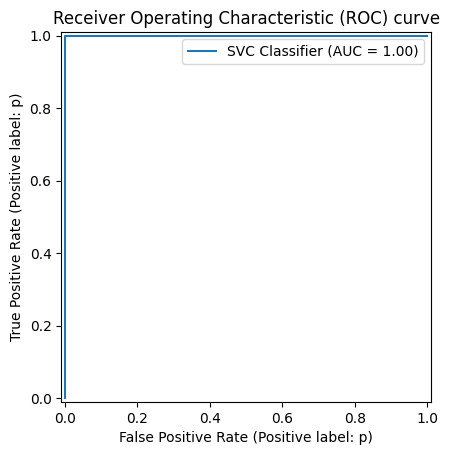

In [ ]:
# Create curve for the pipe evaluated at the test data
RocCurveDisplay.from_estimator(pipe, X_test, y_test, name= "SVC Classifier")

plt.legend()
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.show()

This looks like a perfect ROC curve.

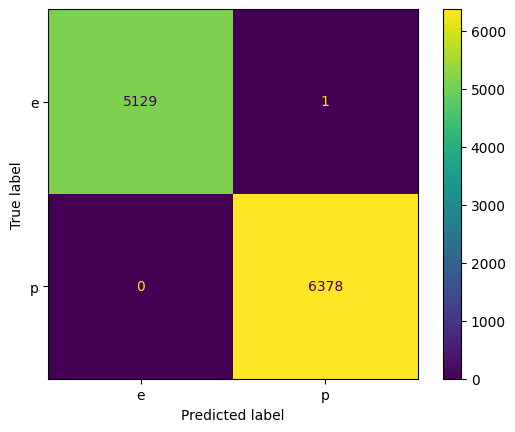

In [ ]:

# Create predictions
predictions = pipe.predict(X_test)
# Create the confuion matrix 
cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
#Create an object that nicely display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

disp.plot()
plt.show()

The confusion matrix shows that my model predicted 5129 of 5130 as true positives. All the poisonous mushrooms were correctly recognized. Only one edible mushroom was wrongly identified as poisonous.<br>
This result is really good! It would be way worse, if a poisonous one would be confused with an edible one.
Therefore, this is a nearly perfect result.

By looking at the ROC curve and the confusion matrix I can say that creating predictions for this kind of data with a svm works perfect as the random forrest in the research paper does. <br>
If there will be released a new dataset with more complex data it is worth to add the svm classifier to the considerable models. 

### Discussion and Conclusion

#### Short summary

My first goal was to classify mushrooms if they are edible or not using some of their characteristics. Based on this dataset I reached this goal easily. <br>
My second goal was to use a svm classifier to perform the classificatioin. This also worked very well.

#### Key takeaways

To work with a lot of catigorical data was one of my biggest fears for this project. <br>
Then I found the OneHotEncoder and with it the Pipeline for setting up a workflow for models. This let me to the decison to take the task. I was a little anxious, because now I had two new topics to deal with.<br>
It took me quite a while and a lot of research, but the pipeline workflow is super well organized and I will use it more often in my future work. It makes it also very easy to make adjustments. <br>
Also the work with the catigorical data was fairly easy. This is very good news in my opion, because there is a lot of this kind of data out there. 

#### Suggestions

The grid search algorithm is very handy, but it took 138 min to execute it. This was also for just a few parameters. If I would do this again or the result would have been worse, I would look into more efficient way to do so. I saw in the documentation that there is a way to perform something like a random parameter test until you pass a certain precision. This would maybe safe a lot of time.